<a href="https://colab.research.google.com/github/sandeep1847e/MSc-Project/blob/main/codes/Jet_2_graph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import uproot
import fastjet as fj
import numpy as np
import awkward as ak

import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

In [4]:
# import requests

# # URL of the .root file
# url = "https://github.com/sandeep1847e/MSc-Project/blob/main/Events/pp24tops100E.root?raw=true"

# # Download the file
# response = requests.get(url)
# with open("pp24tops100E.root", "wb") as file:
#     file.write(response.content)

# print("Download complete!")


Download complete!


In [10]:
file = uproot.open("/home/sandeep-sharma/Desktop/project2/4top_signal.root")
print(file.keys())
tree = file["Delphes;1"]
#print(tree.keys())


['ProcessID0;1', 'Delphes;1']


In [11]:
jet=tree['Jet'].arrays()
len(jet)

5000

In [12]:
jet_pt=jet['Jet.PT']
jet_eta=jet['Jet.Eta']
jet_phi=jet['Jet.Phi']
jet_mass=jet['Jet.Mass']
jet_EbyM=jet["Jet.EhadOverEem"]
# jet_pt
# len(jet_pt)

In [13]:
print(len(jet_pt[0]))
print(len(jet_eta[0]))
print(len(jet_phi[0]))


7
7
7


In [16]:
jet_pt=jet['Jet.PT']
jet_eta=jet['Jet.Eta']
jet_phi=jet['Jet.Phi']
jet_mass=jet['Jet.Mass']



In [16]:
# File paths
signal_file_path = "/home/sandeep-sharma/Desktop/project2/4top_signal.root"
background_file_path = "/home/sandeep-sharma/Desktop/project2/4top_background.root"

def process_root_file(file_path, label, event_offset):
    file = uproot.open(file_path)
    tree = file["Delphes;1"]
    jets = tree["Jet"].arrays()

    # Flatten jet-level features while keeping track of the event
    all_data = []
    for event_no, (jet_pt, jet_eta, jet_phi, jet_mass, jet_EbyM) in enumerate(
        zip(jets["Jet.PT"], jets["Jet.Eta"], jets["Jet.Phi"], jets["Jet.Mass"], jets["Jet.EhadOverEem"])
    ):
        for i in range(len(jet_pt)):
            all_data.append({
                "event_no": event_no + event_offset,  # Offset the event number
                "jet_no": i,
                "jet_pt": jet_pt[i],
                "jet_eta": jet_eta[i],
                "jet_phi": jet_phi[i],
                "jet_mass": jet_mass[i],
                "jet_EbyM": jet_EbyM[i],
                "signal_or_background": label
            })
    
    return pd.DataFrame(all_data)

# Process signal and background files with unique event numbers
signal_data = process_root_file(signal_file_path, label=1, event_offset=0)  # Start signal from 0
background_data = process_root_file(background_file_path, label=0, event_offset=len(signal_data["event_no"].unique()))  # Offset background by signal events count

# Combine signal and background data
final_df = pd.concat([signal_data, background_data], ignore_index=True)

# Save to CSV
output_path = "/home/sandeep-sharma/Desktop/project2/jet_data.csv"
final_df.to_csv(output_path, index=False)
print(f"Processed data saved to {output_path}")


Processed data saved to /home/sandeep-sharma/Desktop/project2/jet_data.csv


In [32]:
import torch
from torch_geometric.data import Data, Dataset, DataLoader
import pandas as pd
import numpy as np
import torch.nn.functional as F
from torch.nn import Linear
from torch_geometric.nn import GCNConv

# Constants
DELTA_R_THRESHOLD = 0.4

# Function to create a graph for a single event
def create_graph(event_data):
    """
    Create a graph for a single event.
    Jets are nodes, and edges are created based on ΔR proximity.
    """
    # Extract node features (jet properties)
    node_features = torch.tensor(event_data[["jet_pt", "jet_eta", "jet_phi", "jet_mass", "jet_EbyM"]].values, dtype=torch.float)
    
    # Extract jet positions for edge creation
    eta = event_data["jet_eta"].values
    phi = event_data["jet_phi"].values
    num_jets = len(eta)
    
    # Create edges based on ΔR < threshold
    edge_index = []
    for i in range(num_jets):
        for j in range(i + 1, num_jets):
            delta_eta = eta[i] - eta[j]
            delta_phi = np.abs(phi[i] - phi[j])
            if delta_phi > np.pi:
                delta_phi = 2 * np.pi - delta_phi
            delta_r = np.sqrt(delta_eta**2 + delta_phi**2)
            if delta_r < DELTA_R_THRESHOLD:
                edge_index.append([i, j])
                edge_index.append([j, i])  # Undirected graph
    
    # Convert edge index to tensor
    if len(edge_index) > 0:
        edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    else:
        edge_index = torch.empty((2, 0), dtype=torch.long)  # No edges
    
    # Event label (signal or background)
    label = torch.tensor([event_data["signal_or_background"].iloc[0]], dtype=torch.long)
    
    # Create a PyTorch Geometric Data object
    graph = Data(x=node_features, edge_index=edge_index, y=label)
    return graph

# Custom Dataset Class
class JetGraphDataset(Dataset):
    def __init__(self, csv_file):
        """
        Initialize the dataset by loading the CSV file.
        """
        self.data = pd.read_csv(csv_file)
        self.events = self.data["event_no"].unique()

    def len(self):
        return len(self.events)

    def get(self, idx):
        """
        Generate a graph for the idx-th event.
        """
        event_no = self.events[idx]
        event_data = self.data[self.data["event_no"] == event_no]
        return create_graph(event_data)

    def indices(self):
        """
        Return a range of indices for the dataset.
        """
        return range(self.len())

    def transform(self, data):
        """
        Placeholder transform method (can be customized).
        """
        return data

# Define a GCN Model
class GCN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GCN, self).__init__()
        self.gcn1 = GCNConv(input_dim, hidden_dim)
        self.gcn2 = GCNConv(hidden_dim, hidden_dim)
        self.fc = Linear(hidden_dim, output_dim)

    def forward(self, data):
        """
        Forward pass for a batch of graphs.
        """
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.gcn1(x, edge_index))  # Apply GCNConv + ReLU activation
        x = F.relu(self.gcn2(x, edge_index))  # Apply second GCNConv + ReLU activation
        x = torch.mean(x, dim=0)  # Graph-level representation (pooling)
        x = self.fc(x)  # Output layer
        return F.log_softmax(x, dim=0)

# Main Training Pipeline
def train_model(csv_file, num_epochs=10, batch_size=32, learning_rate=0.01):
    # Load dataset and dataloader
    dataset = JetGraphDataset(csv_file)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # Model, optimizer, and loss function
    model = GCN(input_dim=5, hidden_dim=32, output_dim=2)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    loss_fn = torch.nn.NLLLoss()  # Negative Log-Likelihood Loss for classification

    # Training loop
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        for batch in dataloader:
            optimizer.zero_grad()
            batch = batch.to('cpu')  # Ensure data is on the correct device
            out = model(batch)
            loss = loss_fn(out, batch.y)  # Batch labels as targets
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {total_loss:.4f}")

    print("Training complete!")
    return model

# Example Usage
if __name__ == "__main__":
    csv_file_path = "/home/sandeep-sharma/Desktop/project2/jet_data.csv"  # Replace with your dataset path
    trained_model = train_model(csv_file_path, num_epochs=10, batch_size=32, learning_rate=0.01)


/home/sandeep-sharma/anaconda3/lib/python3.12/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


RuntimeError: size mismatch (got input: [2], target: [32])

In [20]:
from sklearn.preprocessing import MinMaxScaler

dataframes = []

# Looping through each event
for event_no, (jets_pt, jets_eta, jets_phi, jet_mass) in enumerate(zip(jet_pt, jet_eta, jet_phi, jet_mass), start=1):
    # Create a DataFrame for each event
    event_df = pd.DataFrame({
        'event_no': [event_no] * len(jets_pt),  # Event number for each jet
        'jet_no': list(range(1, len(jets_pt) + 1)),  # Jet number
        'jet_pt': jets_pt,  # Jet transverse momentum
        'jet_eta': jets_eta,  # Jet pseudorapidity
        'jet_phi': jets_phi,  # Jet azimuthal angle
        'jet_mass': jet_mass  # Jet mass
    })
    dataframes.append(event_df)

# Concatenating all DataFrames into a single DataFrame
final_df = pd.concat(dataframes, ignore_index=True)

# Normalize jet properties
#scaler = MinMaxScaler()
#final_df[['jet_pt', 'jet_eta', 'jet_phi','jet_mass']] = scaler.fit_transform(final_df[['jet_pt', 'jet_eta', 'jet_phi','jet_mass']])

distance_threshold = 0.5  
all_graphs = []

for event_no in final_df['event_no'].unique():
    event_data = final_df[final_df['event_no'] == event_no]
    G_event = nx.Graph()

    # Add nodes for each jet in the event
    for idx, row in event_data.iterrows():
        G_event.add_node(row['jet_no'], pt=row['jet_pt'], eta=row['jet_eta'], phi=row['jet_phi'])

    # Add edges based on distance
    for i in range(len(event_data)):
        for j in range(i + 1, len(event_data)):
            # Calculate distance (using normalized pt, eta, phi)
            pt1, eta1, phi1 = event_data.iloc[i][['jet_pt', 'jet_eta', 'jet_phi']]
            pt2, eta2, phi2 = event_data.iloc[j][['jet_pt', 'jet_eta', 'jet_phi']]
            distance = ((eta1 - eta2)**2 + (phi1 - phi2)**2 + (pt1 - pt2)**2)**0.5

            if distance < distance_threshold:
                G_event.add_edge(event_data.iloc[i]['jet_no'], event_data.iloc[j]['jet_no'])

    all_graphs.append(G_event)


In [21]:
final_df.head()

,event_no,jet_no,jet_pt,jet_eta,jet_phi,jet_mass
0,1,1,168.948029,-1.806623,-2.031107,46.233925
1,1,2,130.779541,-1.273731,-2.969492,19.038677
2,1,3,98.353188,-1.665545,1.773501,13.042610
3,1,4,78.188454,-0.760060,0.281581,9.643224
4,1,5,51.535923,-0.745683,1.732738,8.544092


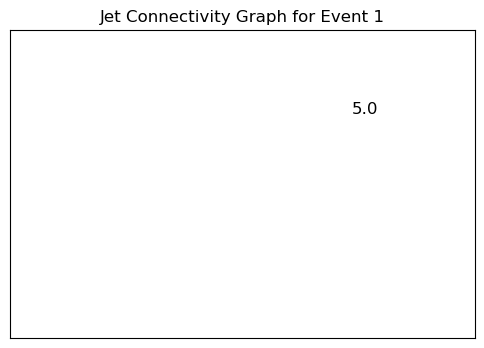

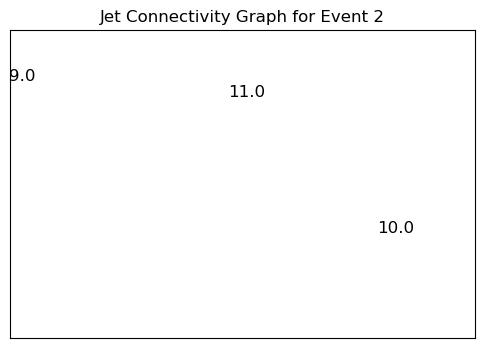

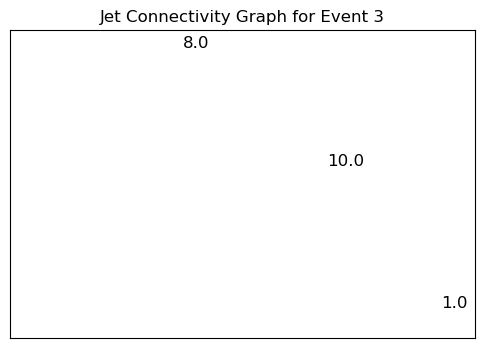

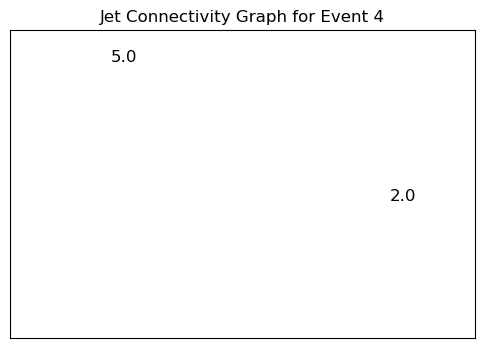

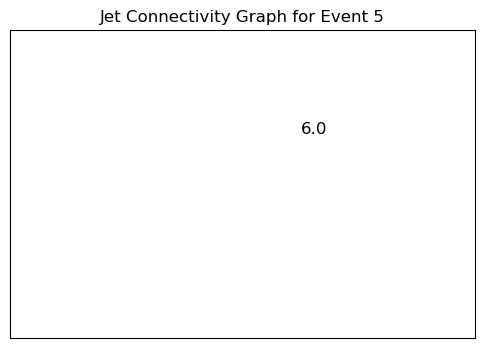

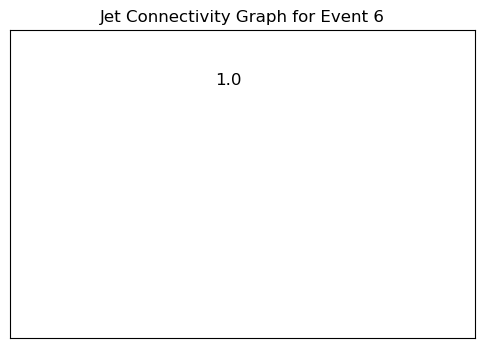

In [23]:
# Now `all_graphs` contains separate graphs for each event
for i, G_event in enumerate(all_graphs[0:6]):
    plt.figure(figsize=(6,4))
    pos = nx.spring_layout(G_event)
    node_sizes = [G_event.degree(n) * 100 for n in G_event.nodes()]  # Adjust node size by degree
    node_colors = [G_event.nodes[n]['pt'] for n in G_event.nodes()]  # Color nodes by pt

    # Draw edges
    nx.draw_networkx_edges(G_event, pos, alpha=0.5, edge_color='gray')

    # Draw labels
    nx.draw_networkx_labels(G_event, pos)
    plt.title(f'Jet Connectivity Graph for Event {i+1}')

plt.show()

In [24]:
for G_event in all_graphs:
    # Create and attach the adjacency matrix as an attribute to the graph
    G_event.graph['adjacency_matrix'] = nx.to_numpy_array(G_event, nodelist=sorted(G_event.nodes()), weight="weight")


In [28]:
for G_event in all_graphs[0:15]:
    adjacency_matrix = G_event.graph['adjacency_matrix']
    print(adjacency_matrix)


[[0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]]
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 

In [27]:
import numpy as np

# Step 1: Determine the maximum number of jets in any event
max_jets = max(len(G_event.nodes) for G_event in all_graphs)

# Step 2: Pad each adjacency matrix to match the max_jets dimension
padded_adjacency_matrices = []

for G_event in all_graphs:
    # Get the adjacency matrix for the current graph
    adjacency_matrix = nx.to_numpy_array(G_event, nodelist=sorted(G_event.nodes()), weight="weight")
    
    # Get the current number of jets for this event
    num_jets = adjacency_matrix.shape[0]
    
    # If the matrix is smaller than max_jets, pad it
    if num_jets < max_jets:
        padded_matrix = np.zeros((max_jets, max_jets))
        padded_matrix[:num_jets, :num_jets] = adjacency_matrix
    else:
        padded_matrix = adjacency_matrix
    
    padded_adjacency_matrices.append(padded_matrix)

# Now `padded_adjacency_matrices` contains square matrices of shape (max_jets, max_jets) for each event


In [23]:
padded_adjacency_matrices[0:5]

[array([[0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 1., 1., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 1., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0.,

In [12]:
# Access event number if available
event_numbers = tree["Event/Event.Number"].array(library="np")

# Access the electrons and muons subbranches
electrons = tree["Electron"]
muons = tree["Muon"]

# Convert to numpy arrays
electron_data = electrons.arrays(["Electron.PT", "Electron.Charge"], library="np")
muon_data = muons.arrays(["Muon.PT", "Muon.Charge"], library="np")

# Now you can analyze the electron and muon data with event information
signal_events = []
background_events = []

for i in range(len(event_numbers)):
    n_electrons = len(electron_data["Electron.PT"][i])  # Assuming 'PT' is an array for electrons
    n_muons = len(muon_data["Muon.PT"][i])            # Assuming 'PT' is an array for muons

    # Check for signal conditions
    if n_electrons + n_muons >= 1:
        signal_events.append(event_numbers[i])  # Store the event number
    elif n_electrons == 2 and np.all(electron_data["Electron.Charge"][i] == electron_data["Electron.Charge"][i][0]):
        signal_events.append(event_numbers[i])
    else:
        background_events.append(event_numbers[i])

# Now you have lists of signal and background event numbers
print(f"Signal events: {len(signal_events)}: {signal_events}")
#print(f"Background events: {len(background_events)}: {background_events}")
signal_events[0]

Signal events: 7656: [array([3]), array([4]), array([5]), array([6]), array([9]), array([12]), array([15]), array([16]), array([17]), array([18]), array([19]), array([21]), array([22]), array([32]), array([33]), array([36]), array([39]), array([46]), array([48]), array([49]), array([50]), array([51]), array([54]), array([56]), array([57]), array([59]), array([61]), array([62]), array([63]), array([65]), array([68]), array([69]), array([73]), array([77]), array([78]), array([79]), array([83]), array([85]), array([86]), array([87]), array([89]), array([92]), array([93]), array([95]), array([98]), array([102]), array([103]), array([104]), array([106]), array([108]), array([115]), array([116]), array([117]), array([121]), array([122]), array([126]), array([127]), array([130]), array([142]), array([151]), array([155]), array([156]), array([162]), array([164]), array([166]), array([167]), array([173]), array([174]), array([179]), array([188]), array([189]), array([190]), array([191]), array(

array([3])

In [13]:
# Check total unique event numbers from the jet data
total_events = len(jet_pt)
unique_event_numbers = set(range(1, total_events + 1))  
total_events

20000

In [14]:
#unique_event_numbers
#signal_events[0].item()
signal_data=np.zeros((total_events))

In [15]:
tree = file["Delphes;1"]
#print(tree.keys())
jet=tree['Jet'].arrays()
jet_pt=jet['Jet.PT']
jet_eta=jet['Jet.Eta']
jet_phi=jet['Jet.Phi']
jet_mass=jet['Jet.Mass']
# jet_pt

In [16]:
import numpy as np
import pandas as pd

# Assuming you have signal_events defined (as in your earlier output)
signal_events_indices = [int(event[0]) for event in signal_events if event.size > 0]  # Extracting event numbers from signal events

# Create an array of size 20000 initialized to 0
event_classification = np.zeros(20000, dtype=int)

# Set the indices of signal events to 1
for index in signal_events_indices:
    if index < 20000:  # Ensure the index is within bounds
        event_classification[index] = 1

# Prepare to collect jet data for each event
dataframes = []

# Example for jet data (this part assumes you have your jet data ready)
for event_no, (jets_pt, jets_eta, jets_phi, jet_mass) in enumerate(zip(jet_pt, jet_eta, jet_phi, jet_mass), start=1):
    # Create a DataFrame for each event
    event_df = pd.DataFrame({
        'event_no': [event_no] * len(jets_pt),
        'jet_no': list(range(1, len(jets_pt) + 1)),
        'jet_pt': jets_pt,
        'jet_eta': jets_eta,
        'jet_phi': jets_phi,
        'jet_mass': jet_mass
    })

    # Add the classification for the jets based on the event classification
    event_df['signal_or_background'] = event_classification[event_no - 1]  # event_no - 1 to get the correct index

    dataframes.append(event_df)

# Concatenating all DataFrames into a single DataFrame
final_df = pd.concat(dataframes, ignore_index=True)

# Count unique events in the final DataFrame
unique_events_in_final = final_df['event_no'].nunique()
print(f"Unique events in final DataFrame: {unique_events_in_final}")
print(final_df.head())


Unique events in final DataFrame: 20000
   event_no  jet_no      jet_pt   jet_eta   jet_phi   jet_mass  \
0         1       1  325.750549 -0.337415 -0.428045  56.044598   
1         1       2  282.529022  0.035443 -2.732777  77.315948   
2         1       3  214.638321 -0.699969 -3.098346  21.759722   
3         1       4  150.365768 -0.098526  2.244453  11.167752   
4         1       5  130.927414 -0.918064 -0.642317  13.407317   

   signal_or_background  
0                     0  
1                     0  
2                     0  
3                     0  
4                     0  


In [17]:
len(final_df)

193228

In [18]:
# Save the final DataFrame as a CSV file
output_file_path = '/home/sandeep/Desktop/pp24tops20KE2.csv'  # Replace with your desired file path
final_df.to_csv(output_file_path, index=False)

print(f"DataFrame saved to {output_file_path}")


DataFrame saved to /home/sandeep/Desktop/pp24tops20KE2.csv
